In [1]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('E:\\SkillFactory\\datatone\\SolarPrediction.csv')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


#### Датасет представляет наблюдения состоящие из следующих признаков: UNIXTime, дата, время, солнечная радиация(вват на м^2), температура(в фаренгейт), атмосферное давление(дюймов Hg столба), влажность, напрвление ветра(градусов), скорость ветра(м/с), время восхода солнца, время захода солнца

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


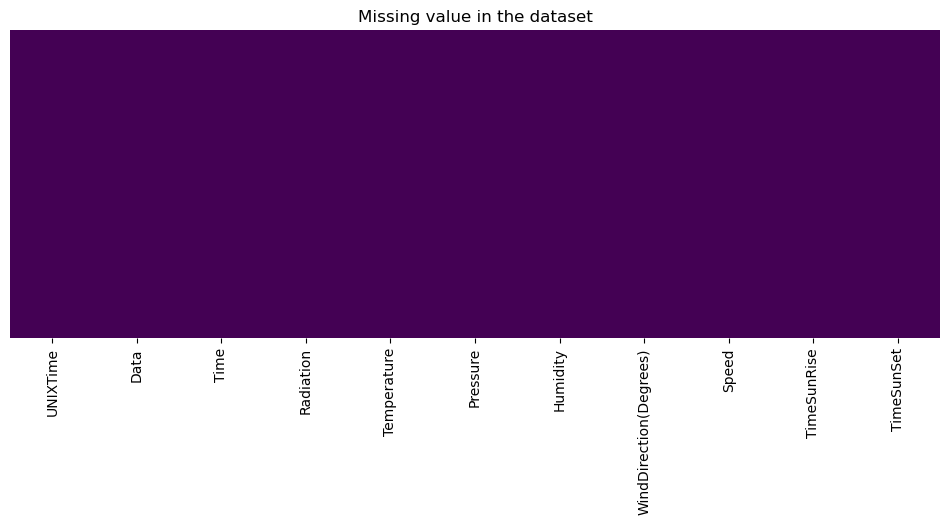

In [4]:
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

### Проверка показала, что пропущенных значений нет

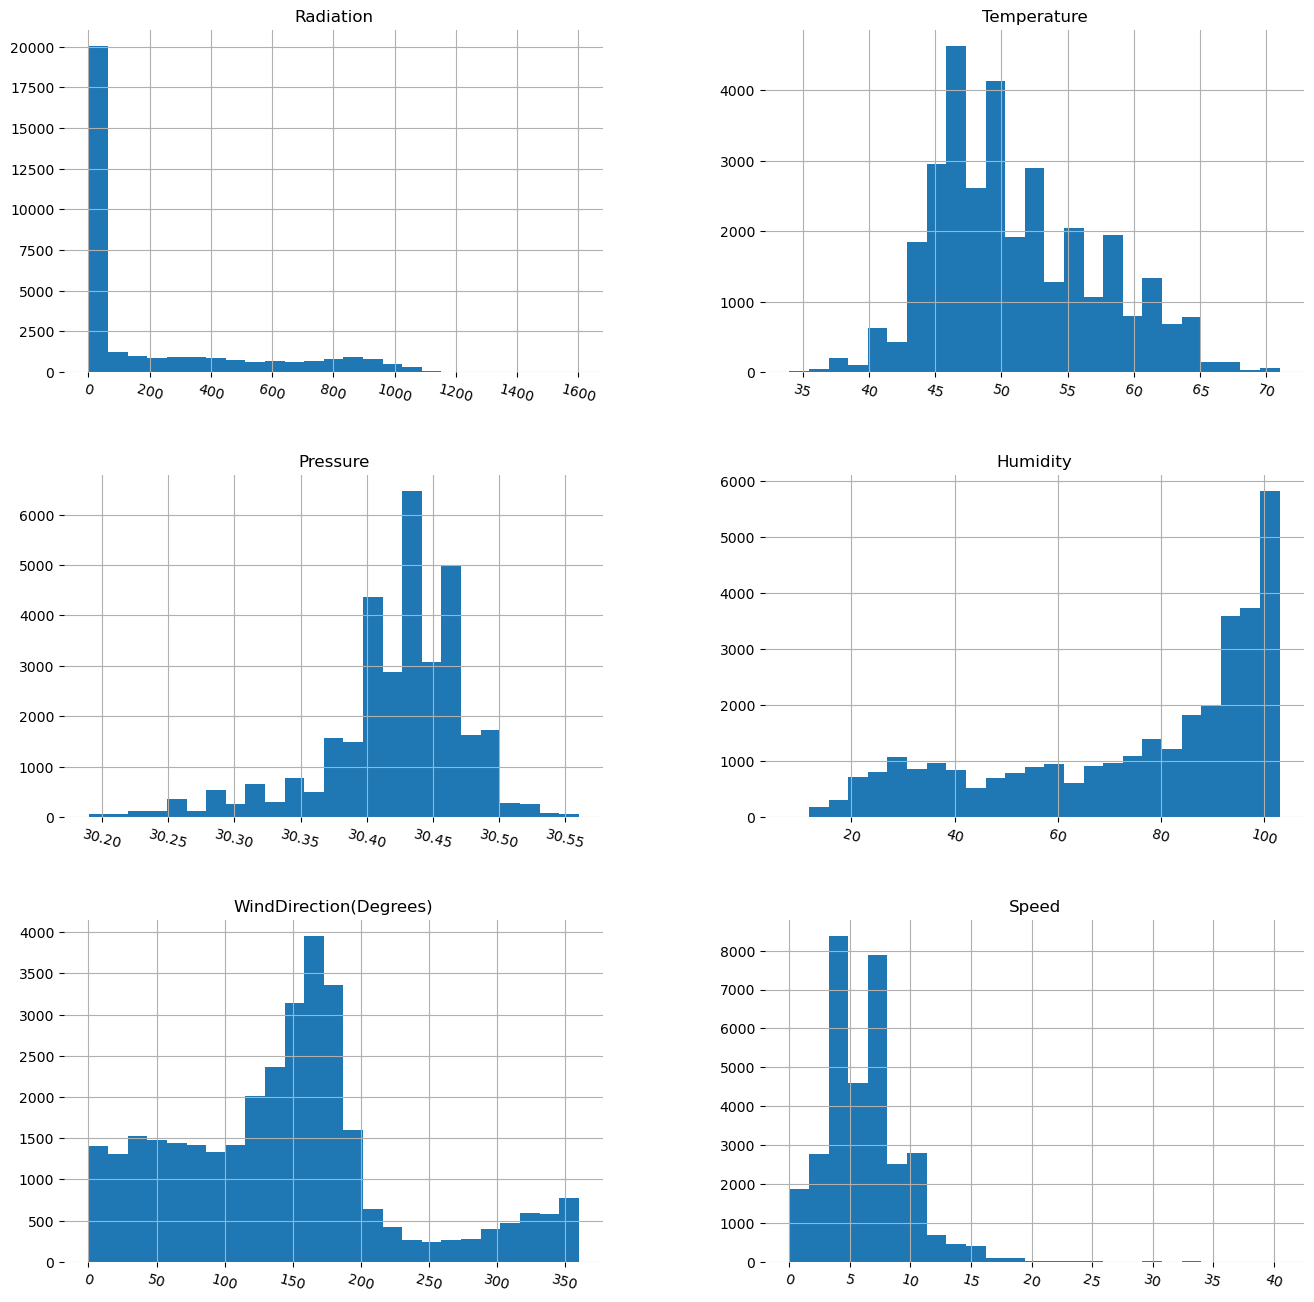

In [4]:
df1=df[['Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

### График солнечной радиаци показывает сильное смещение влево. Предполагаю, что это вызвано тем, что ночные наблюдения показывают тносительное отсутсвие солнечной радиации

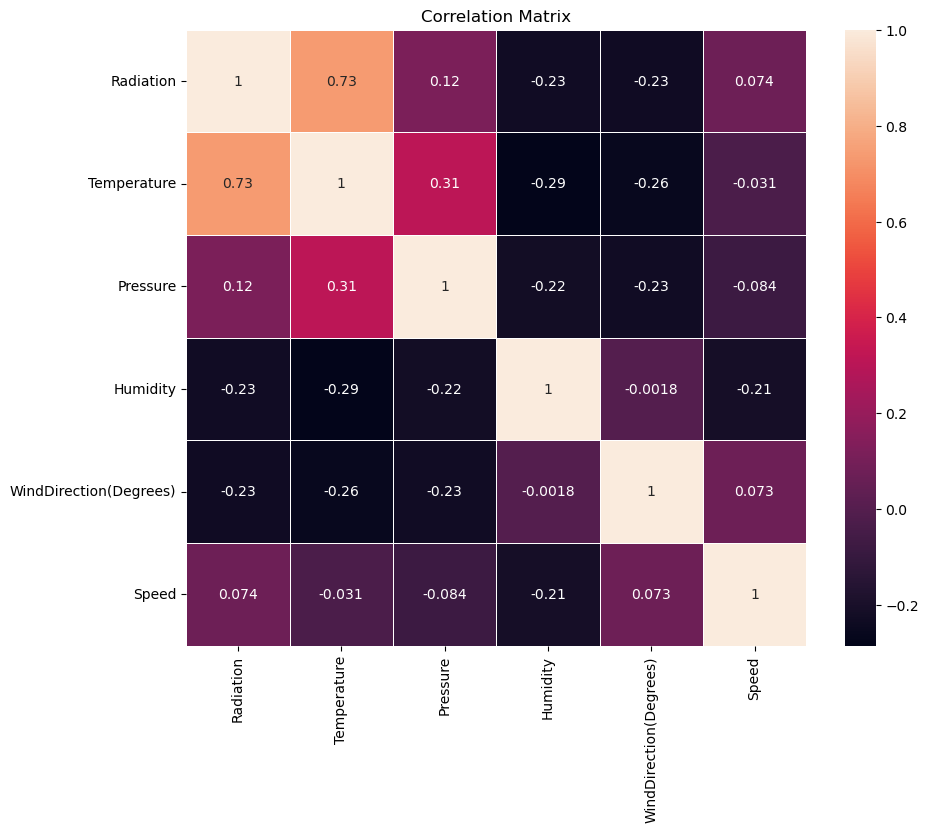

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df1.corr(), annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Промежуточные выводы
#### 1. Наблюдается положительная корреляция  между температурой и радиацией (0,73). Рост температуры соответсвует росту радиации
#### 2. Отрицательная радиация между радиацией и влажностью(-0,23), т.е. при снижении влажности радиация растет
#### 3. Отрицательная радиация между радиацией и направлением ветра(-0,23), т.е. возможно при определенном направлении ветра радиация снижается (может приносит облака)

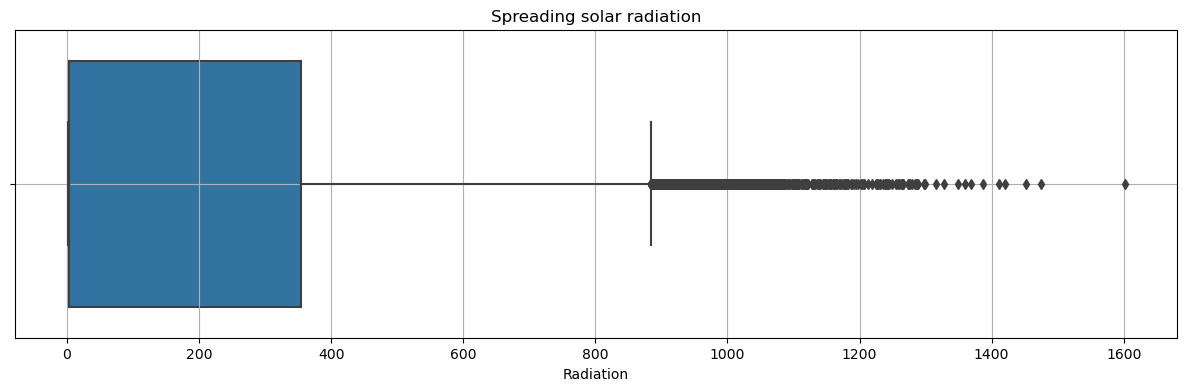

In [4]:
fig= plt.figure(figsize=(15, 4))
boxplot= sns.boxplot(data=df, x='Radiation');
boxplot.set_title('Spreading solar radiation')
boxplot.grid();

### Данный график подтверждает, что распределение солнечной радиации сильно искажено (большое количество выбросов). Это может негативно повлиять на модель предсказания

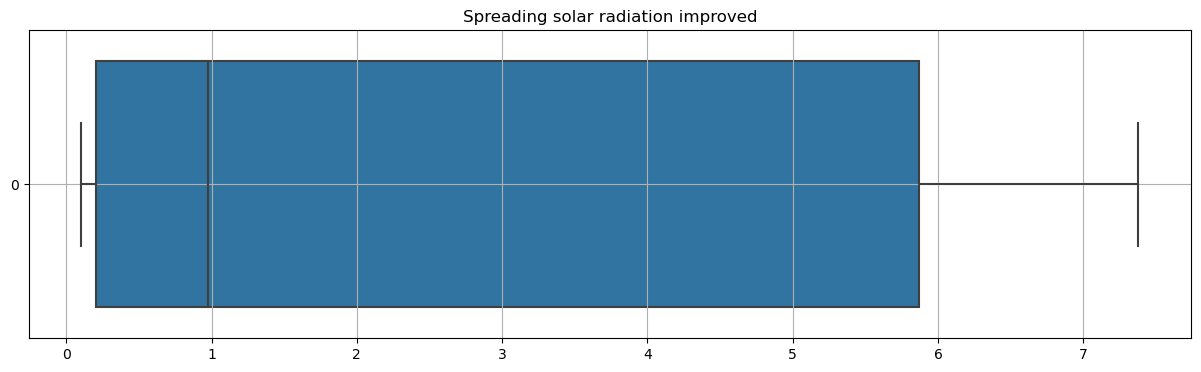

In [7]:
log_target = np.log(df['Radiation'])
fig= plt.figure(figsize=(15, 4))
boxplot= sns.boxplot(log_target, orient='h');
boxplot.set_title('Spreading solar radiation improved')
boxplot.grid();

### Логарифмирование признака солнечная радиация выпрямило распределение. В дальнейшем для построение модели будем использовать этот вариант

In [9]:
X = df[['Temperature', 'Pressure','Humidity', 'WindDirection(Degrees)', 'Speed']]
#y = df['Radiation']
y = log_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
sts = StandardScaler()
X_train = sts.fit_transform(X_train)
X_test = sts.transform(X_test)

In [7]:
from sklearn.linear_model import LinearRegression 
lreg = LinearRegression()
params = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(estimator=lreg, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model_lreg = grid_search.best_estimator_
y_pred = best_model_lreg.predict(X_test)
LinearRegression_mse = mean_squared_error(y_test, y_pred)
print("LinearRegression_mse: ", LinearRegression_mse)

LinearRegression_mse:  3.392301187855505


In [9]:
def predict_solrad_lreg(data):
    print(data)
    data = sts.transform(data)
    predict = best_model_lreg.predict(data)
    print(predict)
    return np.exp(predict)
print(predict_solrad_lreg(X[2:3]))

   Temperature  Pressure  Humidity  WindDirection(Degrees)  Speed
2           48     30.46        57                  158.75   3.37
[0.99749726]
[2.71148719]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rfr, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
RandomForestRegressor_mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)

In [ ]:
RandomForestRegressor_best_params = grid_search.best_params_
print("RandomForestRegressor_best_params: ", RandomForestRegressor_best_params)

In [ ]:
def predict_solrad_rfr(data):
    print(data)
    data = sts.transform(data)
    predict = best_model.predict(data)
    print(predict)
    return np.exp(predict)
print(predict_solrad_rfr(X[2:3]))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 10]
}
grid_search = GridSearchCV(estimator=gbr, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model_gbr = grid_search.best_estimator_
y_pred = best_model_gbr.predict(X_test)
GradientBoostingRegressor_mse = mean_squared_error(y_test, y_pred)
print("GradientBoostingRegressor_mse: ", GradientBoostingRegressor_mse)

In [10]:
GradientBoostingRegressor_best_params = grid_search.best_params_
print("GradientBoostingRegressor_best_params: ", GradientBoostingRegressor_best_params)

GradientBoostingRegressor_best_params:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


In [ ]:
def predict_solrad_gbr(data):
    print(data)
    data = sts.transform(data)
    predict = best_model_gbr.predict(data)
    print(predict)
    return np.exp(predict)
print(predict_solrad_gbr(X[2:3]))

In [10]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(silent=True)
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'subsample': [1.0],
    'colsample_bylevel': [1.0],
    'reg_lambda': [3.0]
}
grid_search = GridSearchCV(estimator=cbr, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_cbr = grid_search.best_estimator_
y_pred = best_cbr.predict(X_test)
CatBoostRegressor_best_params = grid_search.best_params_
print("CatBoostRegressor_best_params: ", CatBoostRegressor_best_params)
CatBoostRegressor_mse = mean_squared_error(y_test, y_pred)
print("CatBoostRegressor_mse: ", CatBoostRegressor_mse)

CatBoostRegressor_best_params:  {'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_lambda': 3.0, 'subsample': 1.0}
CatBoostRegressor_mse:  1.8900775049168157


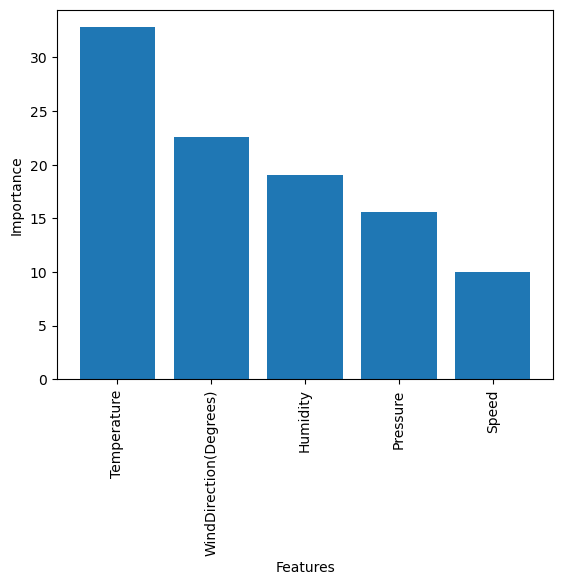

In [14]:
feature_imp = best_cbr.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_imp))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_feature_importances)

plt.bar(features, importances)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [15]:
def predict_solrad_cbr(data):
    print(data)
    data = sts.transform(data)
    predict = best_cbr.predict(data)
    print(predict)
    return np.exp(predict)
print(predict_solrad_cbr(X[3:4]))

   Temperature  Pressure  Humidity  WindDirection(Degrees)  Speed
3           48     30.46        60                  137.71   3.37
[0.93143324]
[2.53814435]
